In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
import tensorflow as tf
import time
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print("tf version:", tf.__version__)
import warnings
warnings.filterwarnings('ignore')

tf version: 2.5.0


In [2]:
directory='./Belgium_Datasets'
train_dir=directory+'/BelgiumTSC_Training/Training'
test_dir=directory+'/BelgiumTSC_Testing/Testing'
trainclasses=os.listdir(train_dir)
testclasses=os.listdir(test_dir)

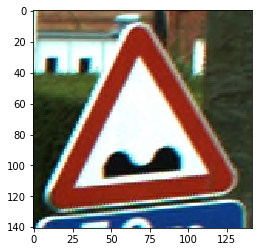

In [3]:
import matplotlib.pyplot as plt
img = load_img('./Belgium_Datasets/BelgiumTSC_Training/Training/00000/01153_00000.ppm')
plt.imshow(img)

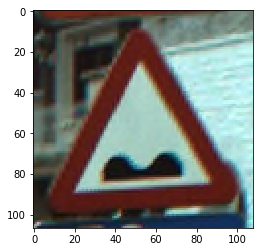

In [4]:
import matplotlib.pyplot as plt
img = load_img('./Belgium_Datasets/BelgiumTSC_Testing/Testing/00000/00017_00000.ppm')
plt.imshow(img)

In [5]:
df=[[]]
df=pd.DataFrame(df)
for i in trainclasses:
    path = "./Belgium_Datasets/BelgiumTSC_Training/Training/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium_Datasets/BelgiumTSC_Training/Training/"+i+'/'+df1["Filename"]
    df=pd.concat([df,df1],ignore_index=True)

df['Rotate']=0
df["length"] = df["Roi.X2"]-df["Roi.X1"]
df["height"] = df["Roi.Y2"]-df["Roi.Y1"]
df=df.dropna()
df.head()
num_of_classes = df["ClassId"].nunique()

In [6]:
df_test=[[]]
df_test=pd.DataFrame(df_test)
for i in trainclasses:
    path = "./Belgium_Datasets/BelgiumTSC_Testing/Testing/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium_Datasets/BelgiumTSC_Testing/Testing/"+i+'/'+df1["Filename"]
    df_test=pd.concat([df_test,df1],ignore_index=True)

df_test['Rotate']=0
df_test["length"] = df_test["Roi.X2"]-df_test["Roi.X1"]
df_test["height"] = df_test["Roi.Y2"]-df_test["Roi.Y1"]
df_test=df_test.dropna()
df_test.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
1,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,108.0,106.0,9.0,9.0,99.0,97.0,30.0,0,90.0,88.0
2,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,52.0,53.0,5.0,5.0,46.0,47.0,30.0,0,41.0,42.0
3,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,70.0,68.0,6.0,6.0,63.0,62.0,30.0,0,57.0,56.0
4,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,75.0,67.0,6.0,6.0,68.0,61.0,30.0,0,62.0,55.0
5,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,74.0,73.0,6.0,6.0,67.0,67.0,30.0,0,61.0,61.0


int64


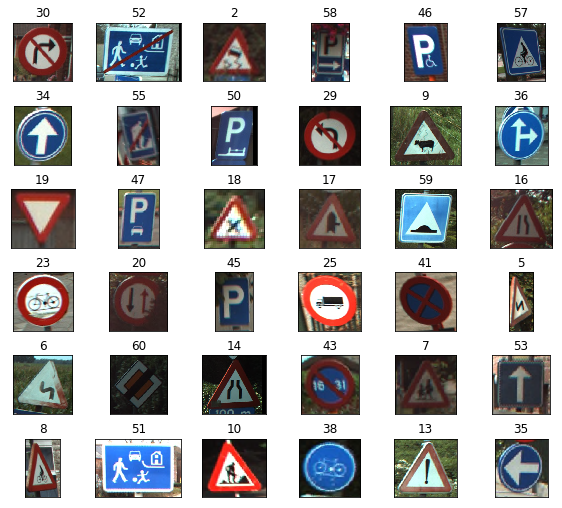

In [7]:
path='./'
df["ClassId"] = df["ClassId"].astype(int)
print(df["ClassId"].dtype)
df_unique = df.copy().drop_duplicates(subset=["ClassId"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})
# print(df_unique)
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(path + str(df_unique.Filename[i])))
    ax.set_title(df_unique.ClassId[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [8]:
import cv2
path='./'
def img_preprocess(df_input):
    X = []  
    for img_path in df_input:
        img = cv2.imread(path + str(img_path))
        
        if img is None:
            print(f"Image cannot be loaded: {img_path}")
            continue 
        
        img = cv2.resize(img, (30, 30))
        
        img = img / 255.0
        
        X.append(img)
    X = np.array(X)  
    return X

In [9]:
X=img_preprocess(df['Filename'])
# print(X)

In [10]:
y=df['ClassId'].to_numpy()
# print(y)

In [11]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.20,random_state=42)

In [12]:
X_train.shape

(3672, 30, 30, 3)

In [13]:
from tensorflow.keras.layers import Input, Dense, Conv2D, InputLayer, Reshape, MaxPooling2D, Flatten,Dropout, BatchNormalization
from keras.models import Sequential

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(30, 30, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_of_classes, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
starting_time = time.time()
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=1000,verbose=1)

ending_time = time.time()
total_time = ending_time - starting_time
total_time/=60

print("Time taken fit : ",total_time," min")

Epoch 1/1000
115/115 [==============================] - 3s 16ms/step - loss: 2.5903 - accuracy: 0.4148 - val_loss: 1.3329 - val_accuracy: 0.6779
Epoch 2/1000
115/115 [==============================] - 2s 15ms/step - loss: 0.8441 - accuracy: 0.7968 - val_loss: 0.6394 - val_accuracy: 0.8346
Epoch 3/1000
115/115 [==============================] - 2s 14ms/step - loss: 0.4148 - accuracy: 0.8886 - val_loss: 0.4235 - val_accuracy: 0.8901
Epoch 4/1000
115/115 [==============================] - 2s 15ms/step - loss: 0.2444 - accuracy: 0.9284 - val_loss: 0.2657 - val_accuracy: 0.9249
Epoch 5/1000
115/115 [==============================] - 2s 15ms/step - loss: 0.1404 - accuracy: 0.9611 - val_loss: 0.1942 - val_accuracy: 0.9423
Epoch 6/1000
115/115 [==============================] - 2s 15ms/step - loss: 0.1084 - accuracy: 0.9679 - val_loss: 0.1533 - val_accuracy: 0.9434
Epoch 7/1000
115/115 [==============================] - 2s 15ms/step - loss: 0.0834 - accuracy: 0.9804 - val_loss: 0.0932 - val_ac

In [16]:
df_test["ClassId"] =df_test["ClassId"].astype(int)
print("Number of Test Images are ", len(df_test))
df_test.dropna()
df_test.head()

Number of Test Images are  2534


,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
1,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,108.0,106.0,9.0,9.0,99.0,97.0,30,0,90.0,88.0
2,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,52.0,53.0,5.0,5.0,46.0,47.0,30,0,41.0,42.0
3,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,70.0,68.0,6.0,6.0,63.0,62.0,30,0,57.0,56.0
4,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,75.0,67.0,6.0,6.0,68.0,61.0,30,0,62.0,55.0
5,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,74.0,73.0,6.0,6.0,67.0,67.0,30,0,61.0,61.0


In [17]:
X_test = img_preprocess(df_test["Filename"])

In [18]:
y_test = df_test["ClassId"].values

In [19]:
y_pred = model.predict(X_test)

In [20]:
y_pred = np.argmax(y_pred, axis=1)

In [21]:
print(y_pred)

[30 30 30 ... 32 32 32]


In [22]:
confusion = confusion_matrix(y_test, y_pred)

# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy*100)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(y_test, y_pred, labels=np.unique(y_pred))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(float(row_data[4]))
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
print("\n\n\n Summarizing the results : ")
report

Total Accuracy:  96.09313338595106

Confusion Matrix:
 [[  3   3   0 ...   0   0   0]
 [  0  27   0 ...   0   0   0]
 [  0   0   7 ...   0   0   0]
 ...
 [  0   0   0 ...  17   0   0]
 [  0   0   0 ...   0   9   2]
 [  0   0   0 ...   0   0 105]]



 Summarizing the results : 


,Class,Precision,Recall,F1-Score,Support
0,0,1.00,0.50,0.67,6
1,1,0.87,1.00,0.93,27
2,2,1.00,1.00,1.00,7
3,3,0.80,0.67,0.73,6
4,4,1.00,0.92,0.96,12
5,5,0.75,1.00,0.86,3
6,6,1.00,0.33,0.50,6
7,7,0.93,0.91,0.92,90
8,8,0.92,1.00,0.96,12
9,9,0.00,0.00,0.00,0


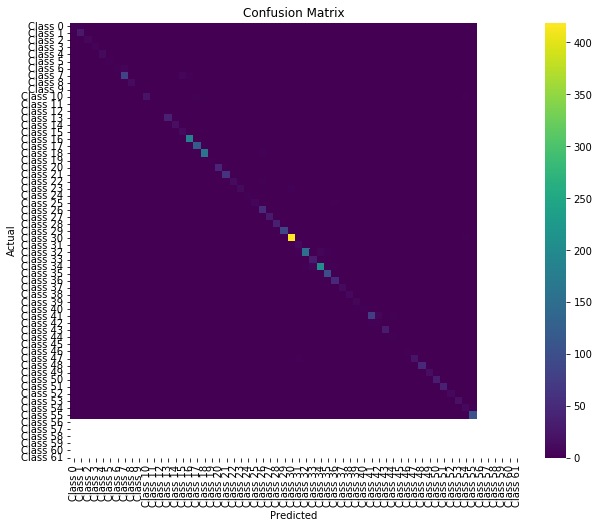

In [23]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()